### import libraries & functions

In [1]:
# import data analysis & viz libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import nlp libraries
import string
import collections
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

# set nlp variables
english_stops = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

In [2]:
# create nlp functions

def clean_tokens(tokens):
    """ Lowercases, takes out punct and stopwords and short strings """
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

def lemmatize(tokens):
    """ Removes plurals """
    return [lemmatizer.lemmatize(token) for token in tokens]

def count_ngrams(tokens,n):
    n_grams = ngrams(tokens, n)
    ngram_freq = collections.Counter(n_grams)
    ngram_freq = ngram_freq.most_common()
    return ngram_freq

def ngram_to_dict(ngram_freq):
    l = []
    for t in ngram_freq:
        l.append((' '.join(t[0]),t[1]))
    return dict(l)

### load & clean data

In [3]:
# load data from pickle
cat = 'physics'
articles = pd.read_pickle('{}_through_2018-11-18'.format(cat))

In [4]:
# merge & drop duplicates
articles = articles.copy()
articles.drop_duplicates('id',inplace=True)

# add month & year column
articles['year'] = pd.to_datetime(articles['year-month'],format='%Y-%m').dt.strftime('%Y')

# put a space at the end of each abstract
articles['abstract+'] = articles['abstract'].apply(lambda abs: abs+' ')

articles.head()

,id,title,categories,abstract,doi,created,updated,authors,year-month,year,abstract+
0,0704.0135,a single trapped ion as a time-dependent harmo...,quant-ph,we show how a single trapped ion may be used t...,10.1103/physreva.76.052105,2007-04-02,2007-07-27,"[menicucci, milburn]",2007-04,2007,we show how a single trapped ion may be used t...
1,0704.0147,a povm view of the ensemble approach to polari...,physics.optics physics.class-ph quant-ph,"statistical ensemble formalism of kim, mandel ...",,2007-04-02,2007-06-20,"[sudha, rao, devi, rajagopal]",2007-04,2007,"statistical ensemble formalism of kim, mandel ..."
2,0704.0202,towards minimal resources of measurement-based...,quant-ph,we improve the upper bound on the minimal reso...,10.1088/1367-2630/9/6/206,2007-04-02,,[perdrix],2007-04,2007,we improve the upper bound on the minimal reso...
3,0704.0214,a schematic model of scattering in pt-symmetri...,quant-ph hep-th,one-dimensional scattering problem admitting a...,,2007-04-02,,[znojil],2007-04,2007,one-dimensional scattering problem admitting a...
4,0704.0340,phonon-mediated decay of an atom in a surface-...,quant-ph,we study phonon-mediated transitions between t...,,2007-04-03,,"[kien, gupta, hakuta]",2007-04,2007,we study phonon-mediated transitions between t...


In [5]:
# group abstracts by month and year
articles_year = articles.groupby('year')['abstract+'].agg(['count','sum'])
articles_year.head()

,count,sum
year,,
1992,3,a pedagogical introduction is given to the qua...
1993,1,measurement is a fundamental notion in the usu...
1994,38,we present numerical results which show how tw...
1995,431,"for classical lattice systems, the dobrushin-l..."
1996,598,the approach to equilibrium for systems intera...


In [6]:
word_dict = {}
bigram_dict = {}
trigram_dict = {}
ngram_dict = {}

for year in articles_year.index:
    tokens = nltk.word_tokenize(articles_year.loc[year,'sum'])
    wc = len(tokens)
    articles_year.loc[year,"word count"] = wc
    clean = clean_tokens(tokens)
    lem = lemmatize(clean)
    
    # count word and ngram frequency
    word_freq = count_ngrams(lem, 1)
    bigram_freq = count_ngrams(lem, 2)
    trigram_freq = count_ngrams(lem, 3)
    ngram_freq = word_freq + bigram_freq + trigram_freq
    
    # change to dict
    word_freq = ngram_to_dict(word_freq)
    bigram_freq = ngram_to_dict(bigram_freq)
    trigram_freq = ngram_to_dict(trigram_freq)
    ngram_freq = ngram_to_dict(ngram_freq)
    
    # add year metadata
    word_dict[year] = word_freq
    bigram_dict[year] = bigram_freq
    trigram_dict[year] = trigram_freq
    ngram_dict[year] = ngram_freq

In [7]:
# pickle ai & ai_year with word count
articles.to_pickle('{}_through_2018-12-08'.format(cat))
articles_year.to_pickle('{}_only_year_through_2018-12-08'.format(cat))

In [8]:
# turn into dfs
def dict_to_df(dictionary, year):
    df = pd.DataFrame(dictionary)
    df.sort_values(year,ascending=False, inplace=True)
    
    return df

word_df = dict_to_df(word_dict,'2018')
bigram_df = dict_to_df(bigram_dict,'2018')
trigram_df = dict_to_df(trigram_dict,'2018')

word_df.head()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
quantum,16.0,5.0,66.0,723.0,1033.0,1279.0,1710.0,2174.0,2735.0,3446.0,...,4934.0,5349.0,8927.0,10388.0,10647.0,11740.0,12950.0,13768.0,14937.0,16028.0
state,1.0,3.0,24.0,264.0,459.0,677.0,1007.0,1470.0,1831.0,2143.0,...,3463.0,3623.0,5751.0,6653.0,6667.0,7007.0,7247.0,7929.0,8298.0,7907.0
system,6.0,4.0,17.0,237.0,335.0,433.0,584.0,740.0,934.0,1150.0,...,1982.0,2280.0,3884.0,4379.0,4526.0,4926.0,5322.0,5812.0,5898.0,6047.0
show,NaN,NaN,5.0,102.0,148.0,203.0,316.0,470.0,564.0,707.0,...,1230.0,1334.0,2104.0,2407.0,2598.0,2748.0,3013.0,3251.0,3239.0,3183.0
two,NaN,NaN,11.0,80.0,139.0,221.0,313.0,459.0,555.0,737.0,...,1212.0,1340.0,2049.0,2293.0,2292.0,2545.0,2534.0,2736.0,2736.0,2748.0


In [10]:
# store as pickle files
word_df.to_pickle('{}_words_df'.format(cat))
bigram_df.to_pickle('{}_bigrams_df'.format(cat))
trigram_df.to_pickle('{}_trigrams_df'.format(cat))

In [11]:
# store as csv files
word_df.to_csv('{}_words_df.csv'.format(cat))
bigram_df.to_csv('{}_bigrams_df.csv'.format(cat))
trigram_df.to_csv('{}_trigrams_df.csv'.format(cat))

### import cleaned data

In [13]:
# import from pickle files
articles_year = pd.read_pickle('{}_only_year_through_2018-12-08'.format(cat))

word_df = pd.read_pickle('{}_words_df'.format(cat))
bigram_df = pd.read_pickle('{}_bigrams_df'.format(cat))
trigram_df = pd.read_pickle('{}_trigrams_df'.format(cat))

In [14]:
word_df.head()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
quantum,16.0,5.0,66.0,723.0,1033.0,1279.0,1710.0,2174.0,2735.0,3446.0,...,4934.0,5349.0,8927.0,10388.0,10647.0,11740.0,12950.0,13768.0,14937.0,16028.0
state,1.0,3.0,24.0,264.0,459.0,677.0,1007.0,1470.0,1831.0,2143.0,...,3463.0,3623.0,5751.0,6653.0,6667.0,7007.0,7247.0,7929.0,8298.0,7907.0
system,6.0,4.0,17.0,237.0,335.0,433.0,584.0,740.0,934.0,1150.0,...,1982.0,2280.0,3884.0,4379.0,4526.0,4926.0,5322.0,5812.0,5898.0,6047.0
show,NaN,NaN,5.0,102.0,148.0,203.0,316.0,470.0,564.0,707.0,...,1230.0,1334.0,2104.0,2407.0,2598.0,2748.0,3013.0,3251.0,3239.0,3183.0
two,NaN,NaN,11.0,80.0,139.0,221.0,313.0,459.0,555.0,737.0,...,1212.0,1340.0,2049.0,2293.0,2292.0,2545.0,2534.0,2736.0,2736.0,2748.0


In [15]:
articles_year

,count,sum,word count
year,,,
1992,3,a pedagogical introduction is given to the qua...,823.0
1993,1,measurement is a fundamental notion in the usu...,237.0
1994,38,we present numerical results which show how tw...,3717.0
1995,431,"for classical lattice systems, the dobrushin-l...",47249.0
1996,598,the approach to equilibrium for systems intera...,63853.0
1997,850,the scattering problems of a scalar point part...,89704.0
1998,1245,we invoke the global properties of the actual ...,132267.0
1999,1569,we have shown in that for arbitrary eos and ra...,165901.0
2000,1844,evading formation of the domain walls in cosmo...,199637.0


### frequency per 1000 words

In [16]:
def drop_pre_1998(df):
    for year in range(1993,1999):
        df.drop(str(year),axis=1,inplace=True)
    return df

In [17]:
def calculate_freq(df,n):
    freq_per_n = df.copy()
    freq_per_n.fillna(0,inplace=True)

    for year in freq_per_n.columns:
        wc = articles_year.loc[year,'word count']
        wc_normalized = wc/n
        freq_per_n[year] = freq_per_n[year]/wc_normalized
    
    freq_per_n.reset_index(inplace=True)
    
    return freq_per_n

In [18]:
word_freq_per_1000 = drop_pre_1998(calculate_freq(word_df, 1000))
bigram_freq_per_1000 = drop_pre_1998(calculate_freq(bigram_df, 1000))
trigram_freq_per_1000 = drop_pre_1998(calculate_freq(trigram_df, 1000))

word_freq_per_1000.head()

,index,1992,1999,2000,2001,2002,2003,2004,2005,2006,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,quantum,19.441069,13.104201,13.699865,14.415635,13.659246,13.560139,13.015680,13.308213,12.989484,...,12.267803,12.290364,12.288645,12.899428,12.765682,12.962307,13.292181,13.256945,13.789404,14.643421
1,state,1.215067,8.860706,9.171647,8.964802,9.194480,9.123601,8.663007,8.925681,9.100298,...,8.610337,8.324545,7.916657,8.261446,7.993688,7.736532,7.438489,7.634683,7.660472,7.223954
2,system,7.290401,4.460491,4.678491,4.810790,4.661688,4.823426,4.739390,4.744556,4.964024,...,4.928007,5.238742,5.346600,5.437678,5.426644,5.438869,5.462624,5.596264,5.444862,5.524630
3,show,0.000000,2.833015,2.825128,2.957590,2.932352,3.057057,2.896137,3.212327,3.066378,...,3.058248,3.065124,2.896304,2.988922,3.114985,3.034107,3.092613,3.130326,2.990151,2.908036
4,two,0.000000,2.766710,2.780046,3.083089,3.136435,2.971434,3.110666,3.332152,3.276404,...,3.013494,3.078910,2.820593,2.847361,2.748093,2.809972,2.600956,2.634442,2.525796,2.510614


### gains

In [19]:
def top_freq(freq_df):
    avg_freq = freq_df.copy()
    avg_freq.set_index('index',inplace=True)
    
    # calculate average frequency
    avg_freq['avg freq'] = avg_freq.mean(axis=1)
    
    # keep only top 100
    avg_freq.sort_values('avg freq',ascending=False,inplace=True)
    top_freq = avg_freq.iloc[:100]
    
    return top_freq

def calculate_gains(freq_df):
    gains = freq_df.copy()
    gains['% gain'] = (gains['2018']-gains['1999'])/gains['1999']
    
    gains.sort_values(['% gain','avg freq'],ascending=[False,False],inplace=True)
    
    return gains

In [20]:
def calculate_five_yr_gains(freq_df):
    gains = freq_df.copy()
    gains['% gain'] = (gains['2014-2018']-gains['1999-2003'])/gains['1999-2003']
    
    gains.sort_values(['% gain','avg freq'],ascending=[False,False],inplace=True)
    
    return gains

In [24]:
word_gains = calculate_five_yr_gains(top_freq(calculate_five_year(word_freq_per_1000)))
bigram_gains = calculate_five_yr_gains(top_freq(calculate_five_year(bigram_freq_per_1000)))
trigram_gains = calculate_five_yr_gains(top_freq(calculate_five_year(trigram_freq_per_1000)))

In [25]:
word_gains.head(20)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
noise,0.521074,0.700614,0.799966,0.860234,0.720472,0.650888
coupling,0.723611,0.903260,1.096455,1.186001,0.977332,0.639003
mode,0.679268,0.839991,0.959809,1.089214,0.892070,0.603512
transition,0.644668,0.797734,0.937055,0.970011,0.837367,0.504666
optical,0.851318,1.167067,1.283510,1.278078,1.144993,0.501293
find,0.712015,0.873628,1.002691,1.043848,0.908046,0.466049
correlation,0.841018,0.954502,1.358861,1.232885,1.096817,0.465944
protocol,0.760820,1.104574,0.917037,1.108253,0.972671,0.456657
study,1.093201,1.331006,1.577559,1.533449,1.383804,0.402715


In [26]:
word_gains.tail(20)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
case,1.798728,1.684739,1.617281,1.347617,1.612091,-0.250794
obtained,0.902835,0.863463,0.751230,0.667819,0.796337,-0.260310
theory,2.585320,2.000391,2.009750,1.899407,2.123717,-0.265311
operation,0.864647,0.847044,0.610427,0.629395,0.737878,-0.272079
probability,1.206361,1.085123,0.950217,0.845208,1.021727,-0.299374
general,1.336005,1.102215,0.986023,0.934692,1.089734,-0.300383
paper,1.171673,1.174989,0.958053,0.819049,1.030941,-0.300958
coherent,1.056207,0.773750,0.822638,0.738052,0.847662,-0.301224
possible,0.963506,0.831095,0.741210,0.659343,0.798788,-0.315684


In [27]:
bigram_gains.head(20)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
entanglement entropy,0.007911,0.088621,0.143460,0.176137,0.104032,21.264016
quantum walk,0.054710,0.167048,0.181628,0.204029,0.151854,2.729260
phase transition,0.073756,0.248776,0.277968,0.274895,0.218849,2.727105
spin chain,0.031482,0.134132,0.108746,0.099139,0.093375,2.149108
open quantum,0.060430,0.068623,0.107516,0.163720,0.100072,1.709251
quantum correlation,0.100149,0.134669,0.288545,0.258041,0.195351,1.576577
quantum memory,0.054850,0.103985,0.157048,0.140088,0.113993,1.554038
quantum phase,0.066196,0.196763,0.203155,0.164569,0.157671,1.486067
single photon,0.128110,0.256434,0.270904,0.281107,0.234139,1.194260


In [28]:
bigram_gains.tail(20)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
quantum field,0.258421,0.166908,0.164484,0.137306,0.181780,-0.468672
entangled state,0.622351,0.557094,0.424326,0.327947,0.482930,-0.473051
pure state,0.345993,0.262196,0.211768,0.182251,0.250552,-0.473254
hilbert space,0.465119,0.357945,0.271115,0.241890,0.334017,-0.479939
continuous variable,0.123503,0.125719,0.081152,0.063149,0.098381,-0.488689
harmonic oscillator,0.286716,0.216360,0.185949,0.145558,0.208645,-0.492327
quantum mechanic,1.175707,0.846812,0.689614,0.593950,0.826521,-0.494814
wigner function,0.157190,0.128187,0.085952,0.079403,0.112683,-0.494863
wave packet,0.177082,0.165327,0.133984,0.086085,0.140620,-0.513870


In [29]:
trigram_gains.head(50)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
matrix product state,0.000000,0.029745,0.039198,0.044961,0.028476,inf
quantum fisher information,0.000000,0.005400,0.023109,0.066698,0.023802,inf
quantum critical point,0.000000,0.019839,0.027323,0.018779,0.016485,inf
conformal field theory,0.004743,0.018881,0.028158,0.037636,0.022354,6.934993
quantum many-body system,0.007649,0.015444,0.030341,0.050367,0.025950,5.585017
quantum phase transition,0.022253,0.146553,0.145577,0.106261,0.105161,3.775197
orbital angular momentum,0.014487,0.049363,0.049016,0.063981,0.044212,3.416501
application quantum information,0.009587,0.022444,0.032322,0.039180,0.025884,3.086628
quantum state transfer,0.007546,0.035323,0.020565,0.026506,0.022485,2.512657


In [30]:
trigram_gains.tail(20)

,1999-2003,2004-2008,2009-2013,2014-2018,avg freq,% gain
index,,,,,,
local unitary transformation,0.023299,0.027388,0.016578,0.008044,0.018827,-0.654737
rev lett \bf,0.036814,0.036237,0.018238,0.012698,0.025997,-0.655078
local hidden variable,0.055755,0.026300,0.024006,0.018692,0.031188,-0.664744
entangled state two,0.022337,0.030324,0.015037,0.007096,0.018699,-0.682310
quantum mechanical system,0.048876,0.026553,0.019855,0.015355,0.027660,-0.685842
quantum fourier transform,0.030174,0.023229,0.014019,0.009445,0.019217,-0.686988
magnetic resonance nmr,0.041258,0.018485,0.012579,0.012849,0.021293,-0.688556
phys rev \bf,0.043261,0.031681,0.021801,0.013110,0.027463,-0.696955
hidden variable theory,0.038369,0.023739,0.021645,0.011561,0.023828,-0.698687


### word analysis

In [31]:
def select_best(best_of,df):
    best_of_df = df[df['index'].apply(lambda ngram: ngram in best_of)]
    best_of_df = df[df['index'].apply(lambda ngram: ngram in best_of)]
    best_of_df = best_of_df.set_index('index')
    
    return best_of_df

def plot_best(best_of_df):
    best_of_df = best_of_df.T
    plt.figure(figsize=(15,5))
    plt.plot(best_of_df.index,best_of_df)
    plt.legend(best_of_df.columns)
    sns.despine(left=True,bottom=True)

# def plot_heatmap(best_of_df):
#     ax = sns.heatmap(best_of_df)

def calculate_five_year(freq_df):
    five_year = pd.DataFrame()
    five_year['index'] = freq_df['index']
    five_year['1999-2003'] = freq_df.loc[:,[str(year) for year in range(1999,2004)]].mean(axis=1)
    five_year['2004-2008'] = freq_df.loc[:,[str(year) for year in range(2004,2009)]].mean(axis=1)
    five_year['2009-2013'] = freq_df.loc[:,[str(year) for year in range(2009,2014)]].mean(axis=1)
    five_year['2014-2018'] = freq_df.loc[:,[str(year) for year in range(2014,2019)]].mean(axis=1)
    
    return five_year

#### words

Index(['noise', 'coupling', 'mode', 'transition', 'optical'], dtype='object', name='index')

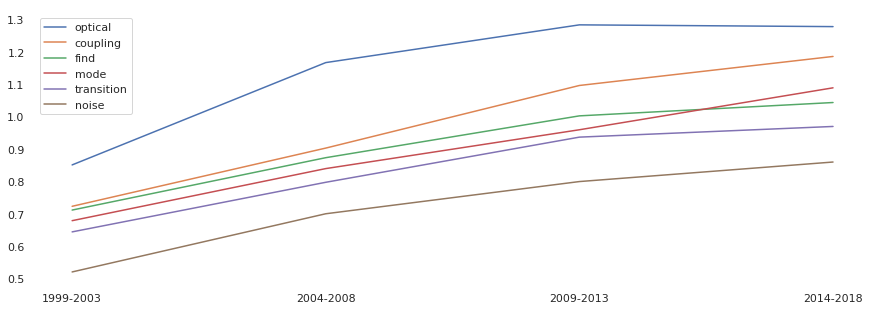

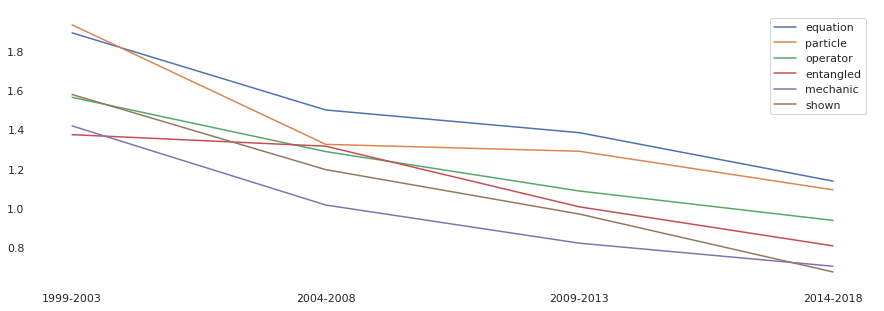

In [40]:
# gains cleaned
words_up = word_gains.head(6).index
words_down = word_gains.tail(6).index

plot_best(select_best(words_up,calculate_five_year(word_freq_per_1000)))
plot_best(select_best(words_down,calculate_five_year(word_freq_per_1000)))

Text(66.5,0.5,'')

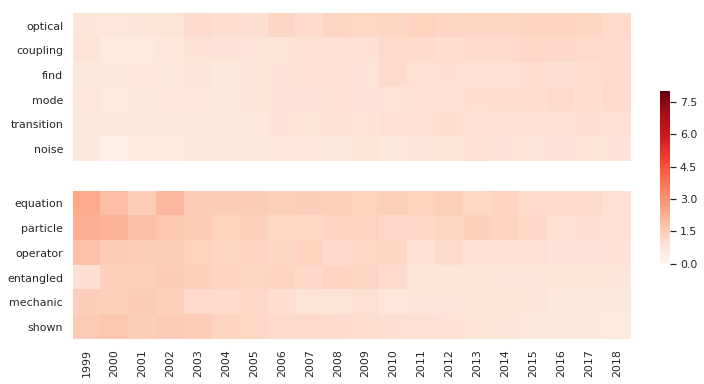

In [54]:
sns.set(style='white')

gains = select_best(words_up,word_freq_per_1000).iloc[:,1:]
losses = select_best(words_down,word_freq_per_1000).iloc[:,1:]

fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
cbar_ax = fig.add_axes([.94, .3, .015, .4])
sns.heatmap(gains,ax=ax[0],vmin=0,vmax=8,cbar_ax=cbar_ax,cmap="Reds")
sns.heatmap(losses,ax=ax[1],vmin=0,vmax=8,cbar_ax=cbar_ax,cmap="Reds")

#remove y label
ax[0].set_ylabel('')
ax[1].set_ylabel('')

Text(66.5,0.5,'')

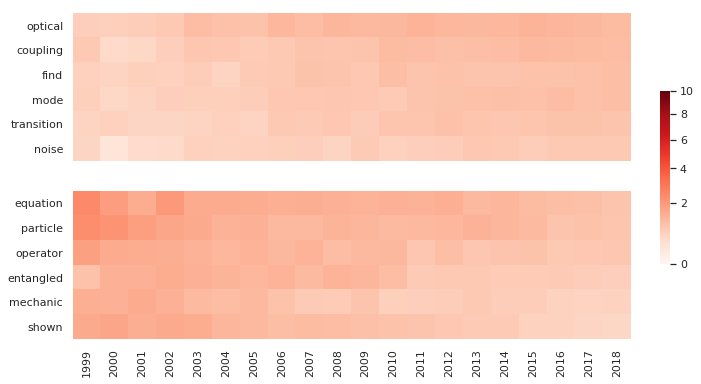

In [55]:
# power normalized
from matplotlib.colors import PowerNorm

sns.set(style='white')

# normalize colorbar
power_norm = PowerNorm(gamma=0.65)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
cbar_ax = fig.add_axes([.94, .3, .015, .4])
hm1 = sns.heatmap(gains,ax=ax[0],vmin=0,vmax=10,norm=power_norm,cbar_ax=cbar_ax,cmap="Reds")
hm2 = sns.heatmap(losses,ax=ax[1],vmin=0,vmax=10,norm=power_norm,cbar_ax=cbar_ax,cmap="Reds")
# fig.colorbar(hm1,ax=cbar_ax, extend='max')

# remove y label
ax[0].set_ylabel('')
ax[1].set_ylabel('')

#### bigrams

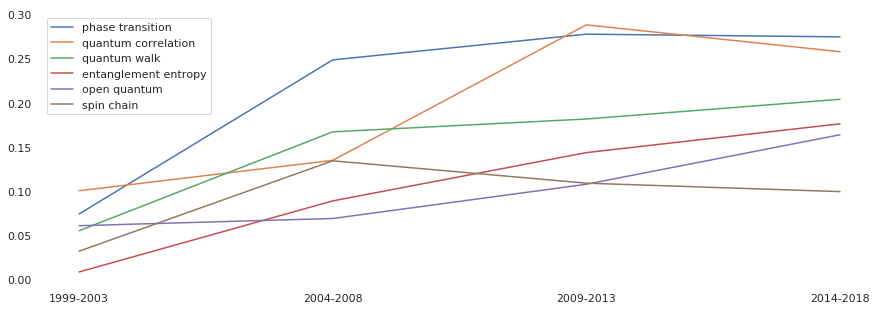

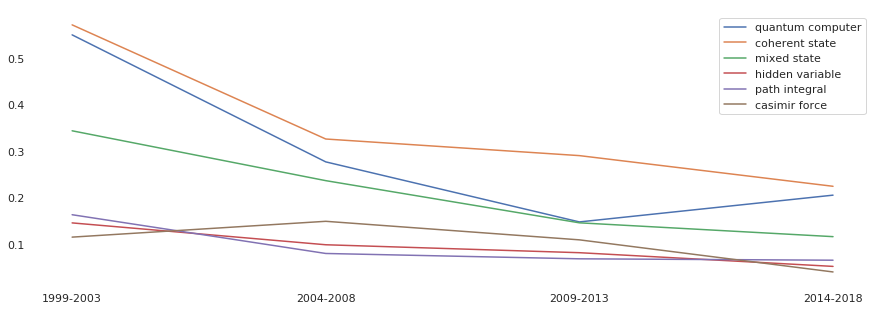

In [42]:
# bigrams cleaned
bigrams_up = bigram_gains.head(6).index
bigrams_down = bigram_gains.tail(6).index

bigram_five_year = calculate_five_year(bigram_freq_per_1000)
bigram_five_year.set_index('index',inplace=True)
bigram_five_year.reset_index(inplace=True)

plot_best(select_best(bigrams_up,bigram_five_year))
plot_best(select_best(bigrams_down,bigram_five_year))



Text(66.5,0.5,'')

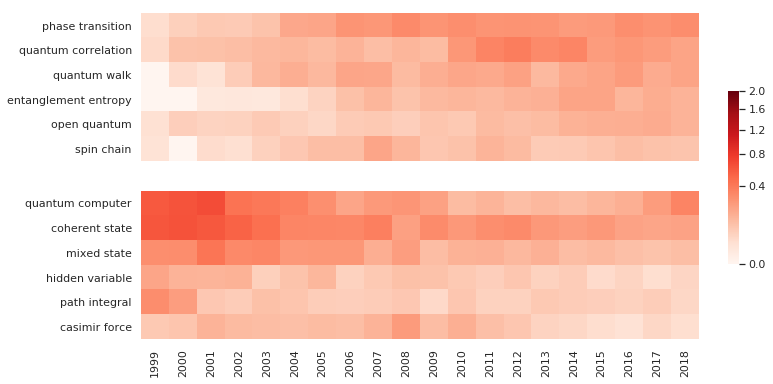

In [47]:
sns.set(style='white')

bigram_freq_tweaked = bigram_freq_per_1000.copy()
bigram_freq_tweaked.set_index('index',inplace=True)
bigram_freq_tweaked.reset_index(inplace=True)

gains = select_best(bigrams_up,bigram_freq_tweaked).iloc[:,1:]
losses = select_best(bigrams_down,bigram_freq_tweaked).iloc[:,1:]

# normalize colorbar
power_norm = PowerNorm(gamma=0.5)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
cbar_ax = fig.add_axes([.94, .3, .015, .4])
sns.heatmap(gains,ax=ax[0],vmin=0,vmax=2,norm=power_norm, cbar_ax=cbar_ax,cmap="Reds")
sns.heatmap(losses,ax=ax[1],vmin=0,vmax=2,norm=power_norm, cbar_ax=cbar_ax,cmap="Reds")

#remove y label
ax[0].set_ylabel('')
ax[1].set_ylabel('')

## Trigrams

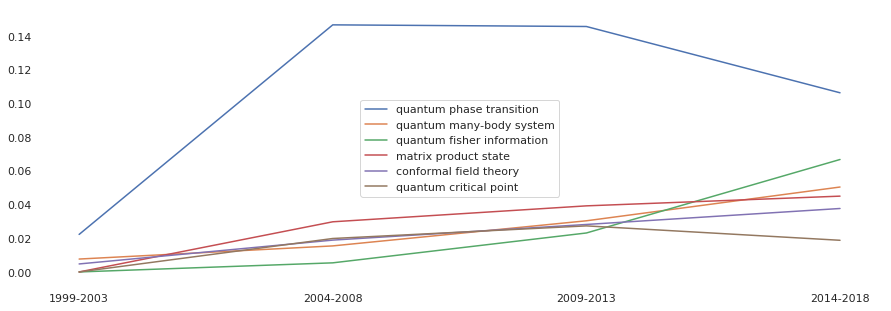

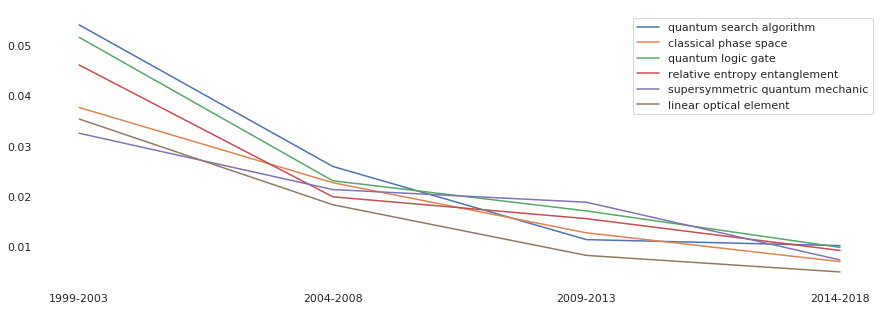

In [59]:
# trigrams cleaned
trigram_up = trigram_gains.head(6).index
trigram_down = trigram_gains.tail(6).index

trigram_five_year = calculate_five_year(trigram_freq_per_1000)
trigram_five_year.set_index('index',inplace=True)
trigram_five_year.reset_index(inplace=True)

plot_best(select_best(trigram_up,trigram_five_year))
plot_best(select_best(trigram_down,trigram_five_year))

Text(66.5,0.5,'')

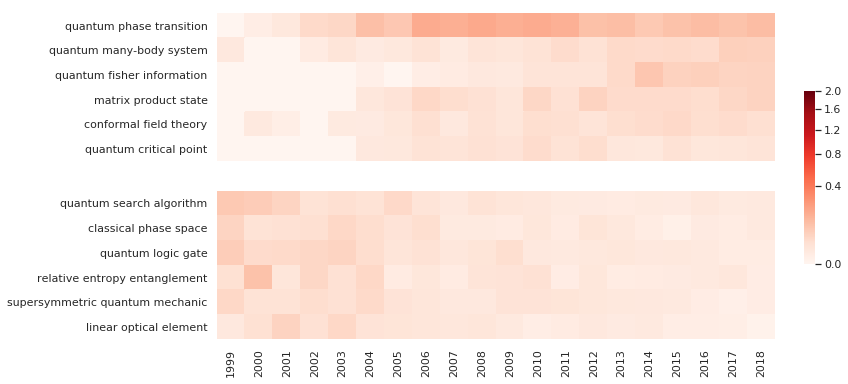

In [60]:
sns.set(style='white')

trigram_freq_tweaked = trigram_freq_per_1000.copy()
trigram_freq_tweaked.set_index('index',inplace=True)
trigram_freq_tweaked.reset_index(inplace=True)

gains = select_best(trigrams_up,trigram_freq_tweaked).iloc[:,1:]
losses = select_best(trigrams_down,trigram_freq_tweaked).iloc[:,1:]

# normalize colorbar
power_norm = PowerNorm(gamma=0.5)

# plot
fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
cbar_ax = fig.add_axes([.94, .3, .015, .4])
sns.heatmap(gains,ax=ax[0],vmin=0,vmax=2,norm=power_norm, cbar_ax=cbar_ax,cmap="Reds")
sns.heatmap(losses,ax=ax[1],vmin=0,vmax=2,norm=power_norm, cbar_ax=cbar_ax,cmap="Reds")

#remove y label
ax[0].set_ylabel('')
ax[1].set_ylabel('')